In [ ]:
# Import all the necessary libraries, classes and functions.
import numpy as np
import timeit
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
# Reset pseudo random generator to a known value so that results are reproducible.
seed = 1
np.random.seed(seed)

## Criação do conjunto de dados

A função objetivo é um polinômio do segundo grau
$$y = 2 + x + 0.5 x^2,$$
onde $a_0=2$, $a_1=1$ e $a_2=0.5$.

Geramos $N= 100$ amostras da função objetivo e as corrompemos com ruído normal padrão.

In [ ]:
# Dataset size.
N = 100

# Generate the feature.
x = 6*np.random.rand(N,1) - 3

# True model (second order function).
y = 2 + x + 0.5*x**2

# Noise.
w = np.random.randn(N, 1)

# Observable function. Noisy version of the true model.
y_noisy = y + w

## Comparando as funções

**OBS**.: As amostras das funções objetivo e observável (i.e., a versão ruidosa da função objetivo) são plotadas como pontos, pois elas são aleatórias.

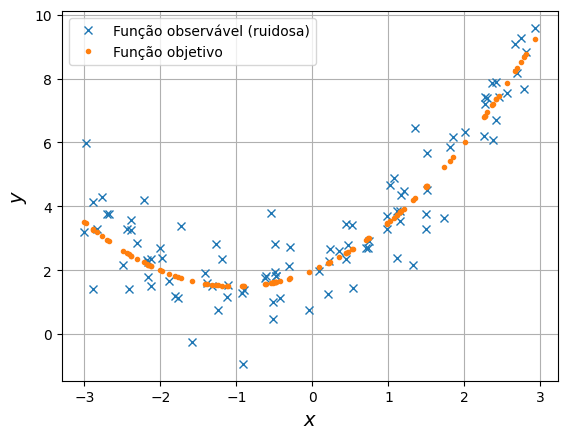

In [ ]:
# Plot original data versus noisy version.
plt.plot(x, y_noisy, 'x', label='Função observável (ruidosa)')
plt.plot(x, y, '.', label='Função objetivo')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
# Show the plot.
plt.show()

## Validação cruzada: *Holdout* (70/30%)

O holdout pode ser implementado através da função `train_test_split`, onde passamos o tamanho, em porcentagem, do conjunto de validação (ou teste) através do parâmetro `test_size`.

In [ ]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Split the whole dataset into random training and validation set.
x_train, x_val, y_train, y_val = train_test_split(x, y_noisy, test_size=0.3, random_state=seed)

# Print size of the datasets.
print('Tamanho do conjunto de treinamento:', len(y_train))
print('Tamanho do conjunto de validação:', len(y_val))

Tamanho do conjunto de treinamento: 70
Tamanho do conjunto de validação: 30


**OBS**.: Como no código abaixo a matriz de atributos polinomial é padronizada, se ela contiver a **coluna do atributo de *bias***, a padronização fará com que os valores desta coluna se tornem todos iguais a zero, fazendo com que o modelo não se ajuste bem aos dados. Portanto, definimos `include_bias=False` para desabilitar a adição da coluna do atributo de bias.

In [ ]:
# Define the orders to be tested.
poly_orders = range(1, 31)

# Lists used to keep training and validation MSEs.
mse_train_vec = []
mse_val_vec = []

# Iterate over the specified degrees.
for d in poly_orders:

    # Instantiate a polynomial.
    poly = PolynomialFeatures(degree=d, include_bias=False)
    # Instantiate a scaler.
    scaler = StandardScaler()
    # Instantiate a linear regressor.
    reg = LinearRegression()

    # Create a pipeline of actions.
    poly_reg = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    # Train the model.
    poly_reg.fit(x_train, y_train)

    # Predict with the training dataset.
    y_train_predict = poly_reg.predict(x_train)

    # Predict with the validation dataset.
    y_val_predict = poly_reg.predict(x_val)

    # Calculate and store the MSE for the validation dataset into an array.
    mse_val_vec.append(mean_squared_error(y_val, y_val_predict))

    # Calculate and store the MSE for the training dataset into an array.
    mse_train_vec.append(mean_squared_error(y_train, y_train_predict))

holdout_time = timeit.default_timer() - starttime
print("Tempo de execução do holdout: %1.4f [s]" % (holdout_time))

Tempo de execução do holdout: 0.1596 [s]


**OBS**.:

+ Tempo médio para execução com $N = 100$ é de aproximadamente $146$ [ms].

+ Esse valor pode variar dependendo do modelo de CPU usada e da quantidade de núcleos e threads.

## Comparando os erros de treinamento e validação para diversos graus de polinômio.

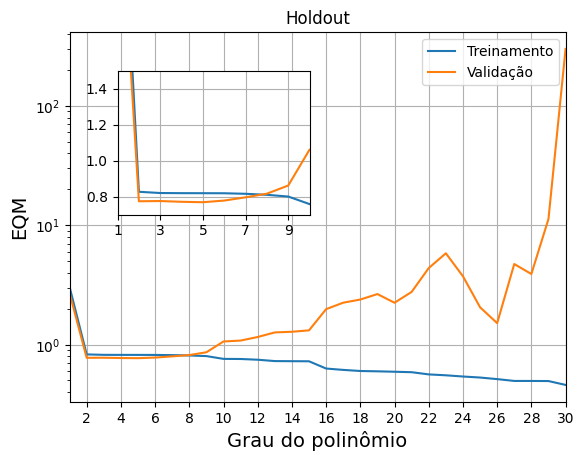

In [ ]:
# Plot results.
fig = plt.figure()
plt.plot(poly_orders, mse_train_vec,  label='Treinamento')
plt.plot(poly_orders, mse_val_vec,  label='Validação')
plt.xlabel('Grau do polinômio', fontsize=14)
plt.ylabel('EQM', fontsize=14)
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.yscale('log')
plt.title('Holdout')
plt.legend()
plt.grid()

left, bottom, width, height = [0.2, 0.5, 0.3, 0.3]
ax1 = fig.add_axes([left, bottom, width, height])
ax1.plot(poly_orders, mse_train_vec,  label='Treinamento')
ax1.plot(poly_orders, mse_val_vec,  label='Validação')
ax1.set_xlim(1, 10)
ax1.set_ylim(0.7, 1.5)
ax1.set_xticks(range(1,11,2))
ax1.grid()

# Show the plot.
plt.show()

+ Ambos os erros iniciam com valores altos ($\to$ subajuste).
    + A função hipótese polinômial não tem flexibilidade o suficiente para capturar o comportamento da função objetivo e, portanto, erra para os dados de ambos os conjuntos.


+ Com o aumento do grau do polinômio, ambos os erros decrescem até uma região onde eles são mínimos.
    + A função hipótese polinômial tem a flexibilidade necessária para capturar o comportamento da função objetivo e, portanto, tem boa capacidade de generalização.


+ Na sequência, ocorre a divergência entre os erros ($\to$ sobreajuste):

    + Erro de treinamento **diminui** conforme o grau do polinômio aumenta.

    + Erro de validação **aumenta** conforme o grau do polinômio aumenta.


+ Qual grau escolher?

    * Valor para o qual ambos os erros sejam mínimos (balanço entre flexibilidade e capacidade de generalização) e que tenha menor complexidade computacional.

## Validação cruzada: $k$-fold ($k$=10)

+ **$k = 10$** *folds*: 10 pares de conjuntos de treinamento e validação, onde para cada par temos:
    + 9 *folds* para treinamento e 1 para validação do modelo.


+ O **$k$-fold** é implementado pela classe `KFold`, onde o parâmetro `n_splits` é usado para configurar o número de *folds*, $k$.


+ Um objeto dessa classe se encarrega de embaralhar (opcional) e dividir o conjunto total de dados em $k$ *folds* (i.e., subconjuntos).
    + O objeto dessa classe fornece os índices dos exemplos dos *folds* de treinamento e validação para cada um dos $k$ treinamentos e validações.


<img src="https://github.com/zz4fap/t319_aprendizado_de_maquina/blob/main/figures/kfold3.png?raw=1" width="500px">


+ Para realizar os treinamentos e validações, usamos a função `cross_val_score`, a qual automatiza os $k$ **pares** de treinamento e validação usando o objeto da classe `KFold` passado para ela.


+ Essa função retorna uma array NumPy (i.e., um vetor) com $k$ **pontuações**, ou seja, uma pontuação para cada um dos $k$ treinamentos e, respectivas, validações.


+ Por ser uma função que calcula **pontuações**, ela retorna valores que quanto maiores, melhor é o modelo sendo avaliado.


+ Porém, em problemas de regressão, estamos interessados na minimização da função do **erro quadrático médio** (EQM), a qual retorna valores que quanto menores, melhor é o modelo sendo avaliado.


+ Portanto, configuramos a **pontuação** da função `cross_val_score` como sendo o valor **negativo do EQM**, ou seja, o valor do EQM é multiplicado por -1.


+ Essa multiplicação transforma o EQM em uma **pontuação**, pois quanto mais próximo de zero (i.e., maior) o valor retornado, melhor será o modelo.


+ Assim, como veremos no código abaixo, configuramos o parâmetro `scoring` (i.e., **pontuação**) da função `cross_val_score` com a string `neg_mean_squared_error`.

In [ ]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the k-Fold object.
# Determines the cross-validation splitting strategy.
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Define the orders to be tested.
poly_orders = range(1, 31)

# Define empty lists for storing the mean error and its standard deviation.
kfold_mean_vec = []
kfold_std_vec = []

# Iterate over the specified degrees.
for d in poly_orders:

    # Instantiate a polynomial.
    poly = PolynomialFeatures(degree=d, include_bias=False)
    # Instantiate a scaler.
    scaler = StandardScaler()
    # Instantiate a linear regressor.
    reg = LinearRegression()

    # Create a pipeline of actions.
    poly_reg = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    # Calculate the cross-validation score with kfold object.
    # OBS.: All scorer objects follow the convention that higher return values are better than lower return values.
    #       Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error,
    #       are available as neg_mean_squared_error which return the negated value of the metric.
    lin_scores = cross_val_score(poly_reg, x, y_noisy, scoring='neg_mean_squared_error', cv=kfold)

    # Converte os scores de volta em valores de EQM.
    scores = -lin_scores
    # Calcula a média dos k EQMs cometidos para os k conjuntos de validação.
    kfold_mean_vec.append(scores.mean())
    # Calcula a estimativa do desvio padrão do EQM.
    kfold_std_vec.append(scores.std())

kfold_time = timeit.default_timer() - starttime
print("Tempo de execução do k-Fold: %1.4f [s]" % (kfold_time))

Tempo de execução do k-Fold: 1.1206 [s]


**OBS**.: Tempo médio para execução com $N = 100$ exemplos e $k = 10$ é de aproximadamente $1.42$ [s].

As figuras abaixo apresentam para **cada grau de polinômio avaliado**:

+ A média dos $k$ valores de EQM de validação.


+ A estimativa do desvio padrão calculada com os $k$ valores de EQM.

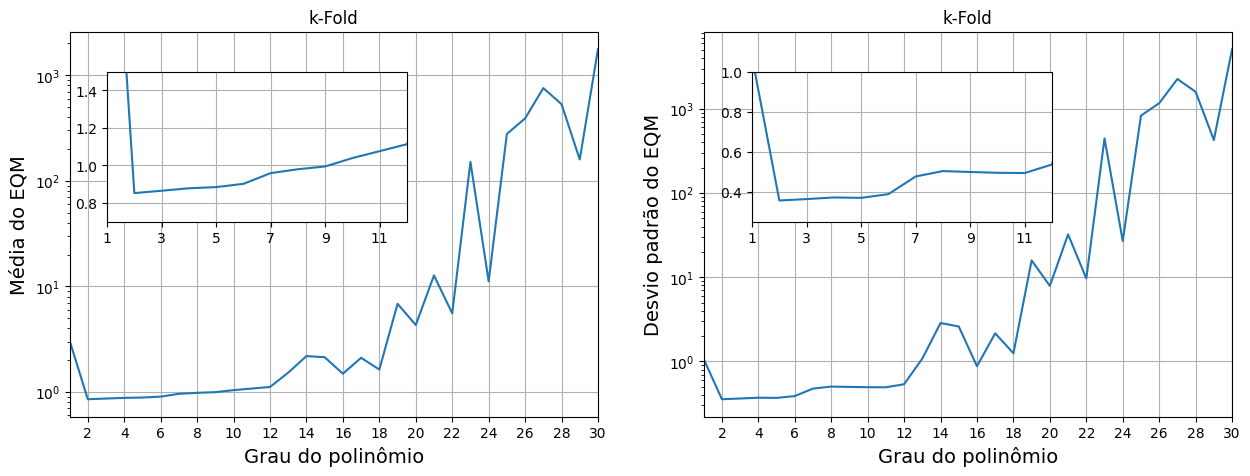

In [ ]:
# Plot results.
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(poly_orders, kfold_mean_vec, label='EQM')
plt.yscale('log')
plt.xlabel('Grau do polinômio', fontsize=14)
plt.ylabel('Média do EQM', fontsize=14)
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.grid()
plt.title('k-Fold')

left, bottom, width, height = [0.15, 0.5, 0.2, 0.3]
ax1 = fig.add_axes([left, bottom, width, height])
ax1.plot(poly_orders, kfold_mean_vec)
ax1.set_xlim(1, 12)
ax1.set_ylim(0.7, 1.5)
ax1.set_xticks(range(1,13,2))
ax1.grid()

ax = plt.subplot(1, 2, 2)
plt.title('k-Fold')
plt.plot(poly_orders, kfold_std_vec, label='Desvio padrão do EQM')
plt.yscale('log')
plt.xlabel('Grau do polinômio', fontsize=14)
plt.ylabel('Desvio padrão do EQM', fontsize=14)
plt.xticks(range(0, max(poly_orders)+1, 2))
plt.xlim([1, max(poly_orders)])
plt.grid()

left, bottom, width, height = [0.58, 0.5, 0.2, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(poly_orders, kfold_std_vec)
ax2.set_xlim(1, 12)
ax2.set_ylim(0.25, 1.0)
ax2.set_xticks(range(1,13,2))
ax2.grid()

# Show the plot.
plt.show()

+ Média e desvio padrão dos EQMs iniciam com valores altos ($\to$ subajuste).
+ Com o aumento do grau do polinômio, ambos decrescem, atingindo o valor mais baixo de EQM para um grau igual a $2$.
+ Porém, conforme o grau do polinômio continua a aumentar, a média e o desvio padrão do EQM começam a aumentar ($\to$ sobreajuste).
+ Qual grau escolher?
    * Valor para o qual ambos, média e desvio padrão do EQM de validação, sejam mínimos e que tenha menor complexidade computacional.

+ Se comparado com os valores de EQM do *holdout*, a indicação de qual grau escolher é mais clara quando usamos o $k$-*fold*.

+ Conforme pode ser visto nos gráficos, valores altos de EQM e desvio padrão são sinais de subajuste ou sobreajuste, sendo o grau ideal encontrado quando ocorre uma mudança de tendência nesses valores.

## Comparação da função objetivo contra sua versão ruidosa e o modelo de regressão polinomial ideal

### Melhor grau: 2

Agora, de posse do melhor grau para um polinômio aproximar os dados, treinamos um novo modelo de regressão polinomial considerando este grau.

Em seguida, calculamos o EQM e comparamos a predição feita pelo melhor regressor polinomial com os dados originais.

EQM: 0.7902604822991764


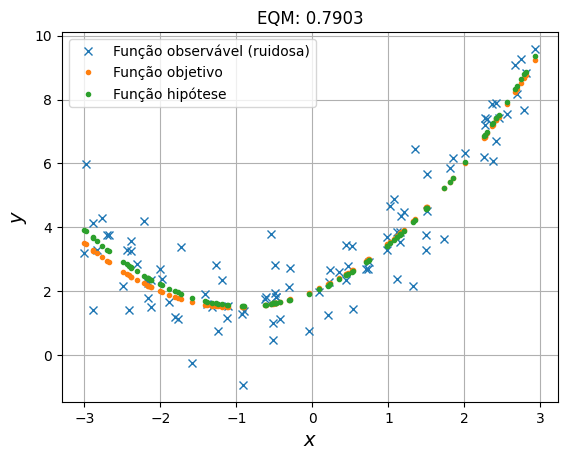

In [ ]:
# Instantiate a polynomial.
poly = PolynomialFeatures(degree=2, include_bias=False)
# Instantiate a scaler.
scaler = StandardScaler()
# Instantiate a linear regressor.
reg = LinearRegression()

# Create a pipeline of actions.
poly_reg = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

# Train the model with the ideal order.
poly_reg.fit(x, y_noisy)

# Predict using the trained model.
y_pred = poly_reg.predict(x)

mse = mean_squared_error(y_noisy, y_pred)
print('EQM:', mse)

# Plot original data versus noisy version and predicted version.
plt.plot(x, y_noisy, 'x', label='Função observável (ruidosa)')
plt.plot(x, y, '.', label='Função objetivo')
plt.plot(x, y_pred, '.', label='Função hipótese')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.title(f'EQM: {mse:.4f}')
plt.legend()
plt.grid()
# Show the plot.
plt.show()